[View in Colaboratory](https://colab.research.google.com/github/liannesr/Lab-7-Machine-Learning/blob/master/Lab07_Lianne_Sanchez.ipynb)

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 7: Feature Engineering - Creating Synthetic Features
* Gain more experience with the LinearRegressor class in TensorFlow by using it to predict median housing price, at the granularity of city blocks.
* Use a validation data set and test set to make sure that our model will generalize and is not overfitting the training data.
* Use test data only after tuning hyperparameters as a measure of how the model will generalize to new data.
* Create synthetic features from the existing features (e.g., taking a ratio of two other features).
* More practice with feature transformations including identifying and clipping (removing) outliers out of the input data to obtain the best model.

### Imports
In this first cell, we import the libraries that we will be using.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
The lab uses [this data](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)  that is based on 1990 census data from California.  Let's load our data set and examine it.

In [84]:
housing_data = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207300.91
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115983.76
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119400.00
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180400.00
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265000.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500001.00


##Prepare Features

As our learning models get more sophisticated, we will want to do some computation on the features and even generate new features from the existing features. For now this method will just make a copy of the portion of the dataframe we plan to use, and re-scale the median-house value (to make it a bit easier to work with).

In [0]:
def prepare_features(dataframe):
  """Prepares the features for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame containing the data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000. This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  return processed_features

###Setting Up the Feature Columns

We define `construct_feature_columns` to define feature columns for the features, that are all numerical for this data set.

In [0]:
NUMERICAL_FEATURES = ["longitude", "latitude", "housing_median_age",
                      "total_rooms", "total_bedrooms","population",
                      "households",	"median_income", "median_house_value"]

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature)
              for feature in NUMERICAL_FEATURES])

### Input Function
We'll continue to use this same input function. You do not need to change this but if you want more detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data and Using the Validation Data

We can now use a lambda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data and also on the validation data.

In [0]:
NUMERICAL_FEATURES = ["households"]
LABEL = "median_house_value"

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_examples[NUMERICAL_FEATURES], validation_examples[LABEL], 
    num_epochs=1, shuffle=False)

### Computing the Loss
We again use RMSE for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method to compute loss that can be tailored to other types of problems.


In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

###Learning Curve

Similar to the last lab we define a function to plot the  **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  This time we will also add the loss on the validation data to the learning curve so that you can see the training loss and validation loss.

In [0]:
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

###Visualizing Our Model Via a Calibration Plot

As in the last lab, we will use a calibration plot to visualize the model.  The x-axis is the predicted target  and the y-axis is the true target. Observe that a model with an RMSE of 0 would have all points on the line target = prediction (shown in the plot).  For points that are under the line, we are overpredicting and points over the line we are underpredicting. 

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

###Configure the LinearRegressor

As in the past labs we provide a method to define our linear regression model. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD).   We again apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm` to ensure that the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

###Train the Model

Our method to train the model that computes the training and validation loss  to add to the learning curve.


In [0]:
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validatin_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print ("Training model...")
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the training loss
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    training_loss = compute_loss(predictions, training_labels)
    training_losses.append(training_loss) 
    
    # Use the predict method to compute the validation loss
    predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    validation_loss = compute_loss(predictions, validation_labels)
    validation_losses.append(validation_loss) 
    print ("  Training loss, Validation loss after period %02d : %0.3f, %0.3f" %(period, training_loss, validation_loss))
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % training_loss) 
  print("Final Loss (RMSE) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and a calibration
  # plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot on Validation Data")
  calibration_plot(predictions, validation_labels)
   
  return linear_regressor

###Create the Training and Validation Data

We load the data, and split it into training and validation sets after first randomizing it to ensure the validation set is repreentative.

In [0]:
housing_data = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

# Randomize the order of the examples before splitting into training
# and validation sets
housing_data = housing_data.reindex(np.random.permutation(housing_data.index))

training_examples = prepare_features(housing_data.head(14000))
validation_examples = prepare_features(housing_data.tail(3000))

### Load the Provided Test Data

This data set (as with many) comes with a provided test data set that is representative and is used to evaluate the final performance. For this data set, the provided test data is located [here](https://storage.googleapis.com/ml_universities/california_housing_test.csv). The purpose of having validation data is to notice overfitting and other problems. Remember our key goal is to train a model that will make good predictions on **new unseen data**. The test data should only be used at the end to see how your final model is performing.  It should not be used in helping select which features to use or to select hyperparameter values.

In [0]:
housing_test_data = pd.read_csv(
    "https://storage.googleapis.com/ml_universities/california_housing_test.csv",
    sep=",")

test_examples = prepare_features(housing_test_data)

## Exercise: Introduce Synthetic Features (1 Point)
Both the total_rooms and population features count totals for a given city block.
But what if one city block were more densely populated than another? Then just using `total_rooms` and `population` directly might not be very useful.  Instead what we really want is the **quadratic feature** obtain by dividing `total_rooms` by the `population` to give the average number of rooms per person for that city block.

We've got you started by creating a feature called rooms_per_person.  Create others, and use them along with whatever other features you think are useful to train a model.

In [166]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000.  This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  # Add your synthetic features here. We've got you started by defining 
  # rooms_per_person
  processed_features["rooms_per_person"] = (dataframe["total_rooms"] / dataframe["population"])
  processed_features["bedrooms_per_person"] = (dataframe["total_bedrooms"]/dataframe["population"])
  processed_features["median_income_per_person"] = (dataframe["median_income"]/dataframe["population"])
  processed_features["people_by_households"] = (dataframe["population"]/dataframe["households"])
  processed_features["median_income_per_household"] = (dataframe["population"]/dataframe["households"])*(dataframe["median_income"]/dataframe["population"])

  return processed_features

# Generate the training, validation and test examples
training_examples = prepare_features(housing_data.head(14000))
validation_examples = prepare_features(housing_data.tail(3000))
test_examples = prepare_features(housing_test_data)

validation_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person,bedrooms_per_person,median_income_per_person,people_by_households,median_income_per_household
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,-119.54,35.61,28.68,2655.66,545.46,1453.11,507.08,3.87,207.39,1.96,0.40,0.00,2.94,0.01
std,1.99,2.13,12.48,2254.53,430.25,1292.15,399.11,1.94,115.96,0.89,0.18,0.01,0.91,0.05
min,-124.30,32.56,2.00,11.00,3.00,13.00,4.00,0.50,15.00,0.21,0.06,0.00,1.17,0.00
25%,-121.77,33.93,18.00,1476.00,301.00,793.00,286.00,2.56,118.45,1.52,0.32,0.00,2.43,0.01
50%,-118.48,34.25,29.00,2126.00,435.50,1171.50,407.50,3.50,182.60,1.93,0.37,0.00,2.83,0.01
75%,-118.00,37.68,37.00,3131.75,650.25,1738.50,603.00,4.72,265.65,2.28,0.44,0.00,3.27,0.01
max,-114.59,41.95,52.00,32054.00,5290.00,35682.00,5050.00,15.00,500.00,17.62,4.21,0.45,21.33,1.93


Since we added new features, we need to add them to `NUMERICAL_COLUMNS`.

In [0]:
# Add any other synthetic features you create to this list.
NUMERICAL_COLUMNS = ["latitude", "longitude", "housing_median_age", 
                     "total_rooms", "total_bedrooms", "population",
                     "households", "median_income", "rooms_per_person", 
                     "bedrooms_per_person", "median_income_per_person", 
                     "people_by_households","median_income_per_household"]

##Exercise -- Add a Clip Feature Transformation (1 point)

Recall that there are two characteristics we'd like of numerical features when used together to train a linear model:
* The range of the features is roughly the same.
* To the extent possible the histogram of the features kind of resembles a bell curve.  Sometimes the data will fit this very well and other times it won't.

Below are the methods to perform linear scaling and log scaling.  For this data set it will also be useful to have a feature transformation to cap the features to within a minimum and/or maximum value.  Most likely you will want to then linearly scale or log scale the feature after clipping it.

In [0]:
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Clip all features to given min and max
def clip(series, clip_to_min, clip_to_max):
  # You need to modify this to actually do the clipping versus just returning
  # the series unchanged
  
  return series.apply(lambda x: clip_to_min if x<clip_to_min else clip_to_max if x>clip_to_max else x)

You can use this function to draw a histogram to help decide what kind of scaling is best to use for `households` and also to confirm your implementation of `clip` works as you intended.

Now let's clip between 0 and 1000 before scaling.


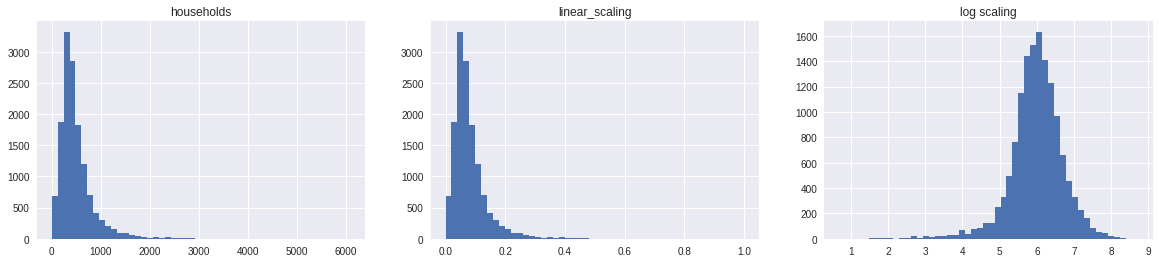

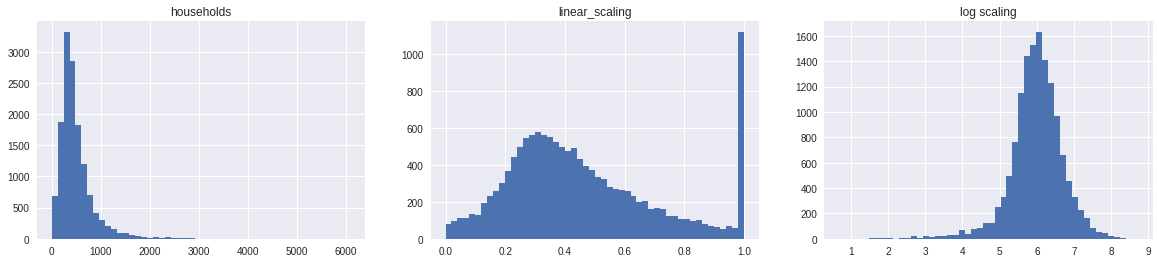

In [115]:
clip_min = -np.inf
clip_max = np.inf

def draw_histograms(dataframe, feature_name,
                    clip_min = -np.inf, clip_max = np.inf):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name)
  histogram = dataframe[feature_name].hist(bins=50)

  plt.subplot(1, 3, 2)
  plt.title("linear_scaling")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name] = linear_scale(
      clip(dataframe[feature_name], clip_min, clip_max))
  histogram = scaled_features[feature_name].hist(bins=50)
  
  plt.subplot(1, 3, 3)
  plt.title("log scaling")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name] = log_scale(dataframe[feature_name])
  histogram = log_normalized_features[feature_name].hist(bins=50)
  
draw_histograms(training_examples, 'households')
print ("Now let's clip between 0 and 1000 before scaling.")

draw_histograms(training_examples, 'households',0, 1000)

Now let's clip between 0 and 1000 before scaling.


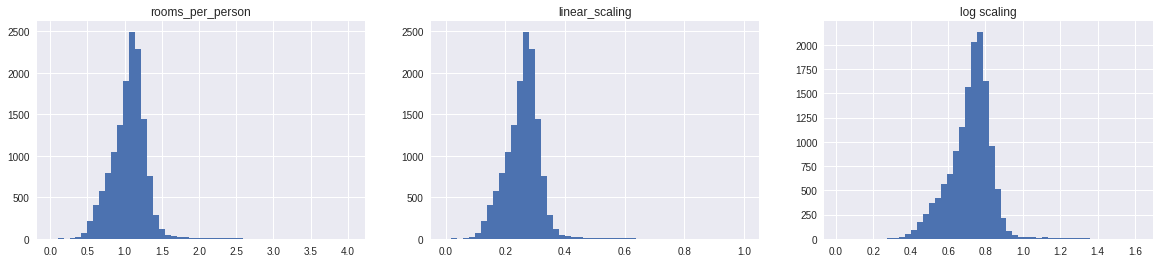

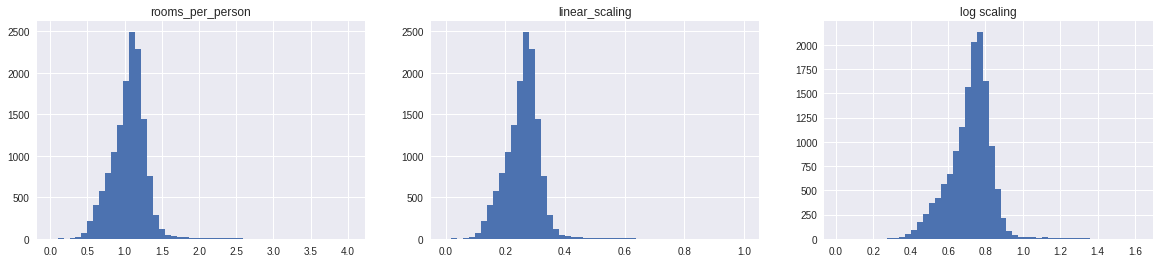

In [127]:
print ("Now let's clip between 0 and 10 before scaling.")
draw_histograms(training_examples, 'rooms_per_person')
draw_histograms(training_examples, 'rooms_per_person', 0, 10)

Now let's clip between 0 and 1000 before scaling.


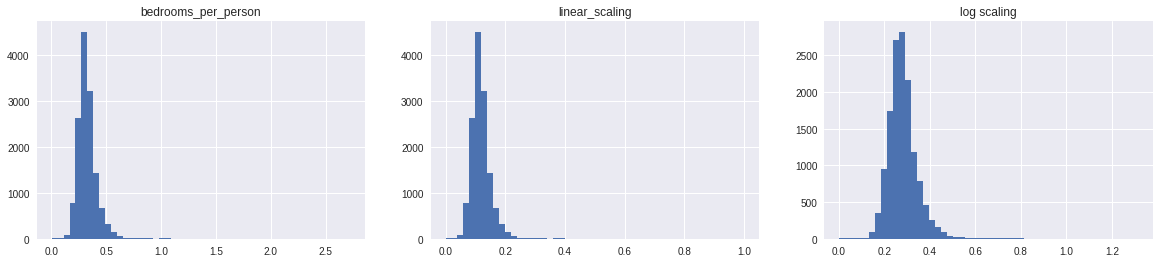

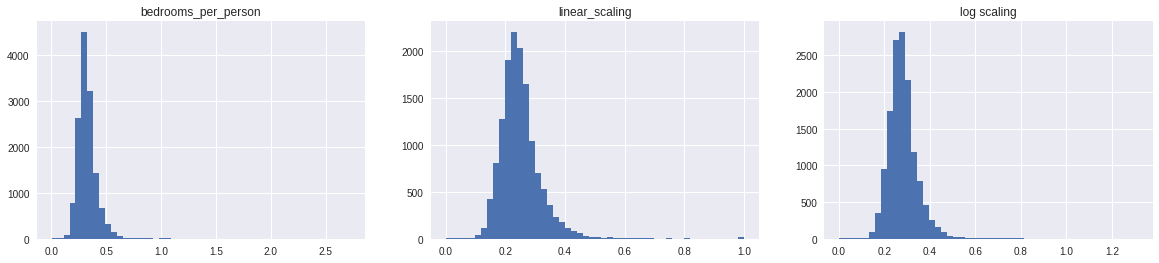

In [131]:
print ("Now let's clip between 0 and 1.3 before scaling.")
draw_histograms(training_examples, 'bedrooms_per_person')
draw_histograms(training_examples, 'bedrooms_per_person', 0, 1.3)

Now let's clip between 0 and 1000 before scaling.


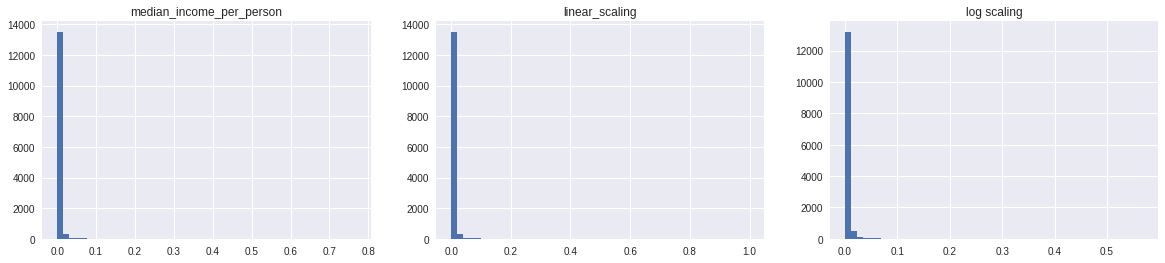

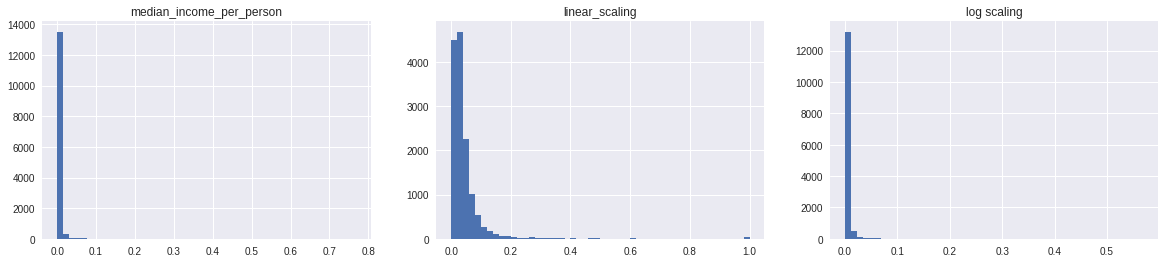

In [140]:
print ("Now let's clip between 0 and 0.1 before scaling.")
draw_histograms(training_examples, 'median_income_per_person')
draw_histograms(training_examples, 'median_income_per_person', 0,0.1)

Now let's clip between 0 and 1000 before scaling.


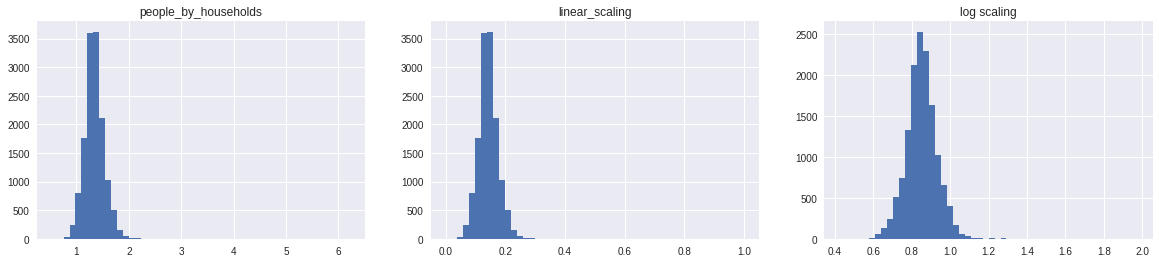

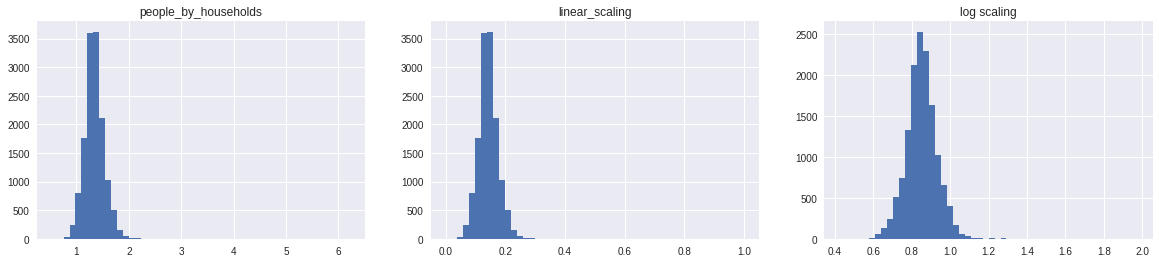

In [135]:
print ("Now let's clip between 0 and 50 before scaling.")
draw_histograms(training_examples, 'people_by_households')
draw_histograms(training_examples, 'people_by_households', 0, 50)

Now let's clip between 0 and 1000 before scaling.


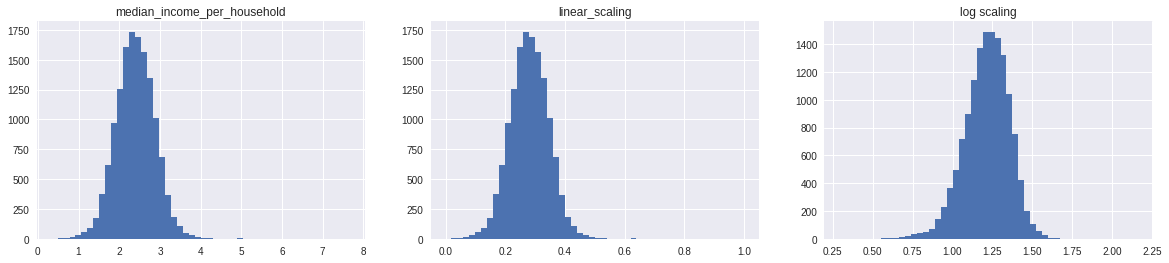

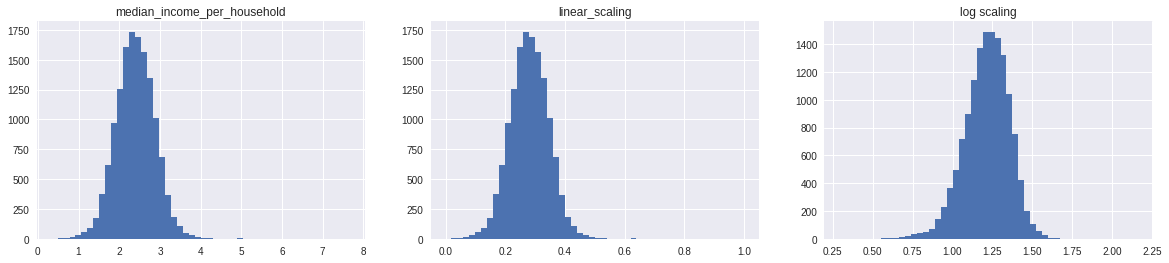

In [136]:
print ("Now let's clip between 0 and 500 before scaling.")
draw_histograms(training_examples, 'median_income_per_household')
draw_histograms(training_examples, 'median_income_per_household', 0,500)

The leftmost histogram is unchanged since that just shows the raw feature.  You should see a very visible change when you clip the feature before applying linear scaling. As you will often (but not always) find, for this particular feature log scaling worked well without the need to first clip the data.

**Run the above code with features other than `households` to help decide what feature normalization to use for each feature.**  Feel free to duplicate the code box that calls `draw_histogram` if you'd like to show the histograms for multiple features.

## Exercise: Train the Best Model You Can (3 points)

We expect you to take some time exploring the feature transformations and hyperparameters.

Select any number of the provided features, create synthetic features you think will be informative, and modify the hyperparmaters to get a better model. You will want to edit preprocess_features to do some feature normalization See how well you are able to do.

**DO NOT APPLY ANY ADDITIONAL FEATURE TRANSFORMATION TO THE TARGET `median_price` since that would change the scale for RMSE.**

* Summarize the changes you made that were the most important.
* Once you find a model, try training 10 times more steps.  Does overfitting occur if you do that?


In [165]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000.  This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  # Perform your feature scaling here
  
  
  # Add your synthetic features here along with the feature scaling you'd like
  # to them. As a starting point linear scaling is used for rooms_per_person. 
  # You are encouraged to experiment with different scaling options.
  processed_features["rooms_per_person"] = (linear_scale(clip(dataframe["total_rooms"]/dataframe["population"], 0, 10)))
  processed_features["bedrooms_per_person"] = (log_scale(dataframe["total_bedrooms"]/dataframe["population"]))
  processed_features["median_income_per_person"] = (linear_scale(clip(dataframe["median_income"]/dataframe["population"], 0, 0.1)))
  processed_features["people_by_households"] = (log_scale(dataframe["population"]/dataframe["households"]))
  processed_features["median_income_per_household"] = linear_scale(clip((dataframe["population"]/dataframe["households"])*(dataframe["median_income"]/dataframe["population"]), 0, 500))
  
  
  return processed_features

# Generate the training, validation and test examples
training_examples = prepare_features(housing_data.head(14000))
validation_examples = prepare_features(housing_data.tail(3000))
test_examples = prepare_features(housing_test_data)

training_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person,bedrooms_per_person,median_income_per_person,people_by_households,median_income_per_household
count,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00
mean,-119.57,35.63,28.57,2641.09,538.11,1424.53,499.97,3.89,207.28,0.20,0.33,0.05,1.35,0.00
std,2.01,2.14,12.61,2163.70,419.61,1114.49,381.33,1.90,115.99,0.08,0.11,0.08,0.20,0.01
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,15.00,0.00,0.00,0.00,0.53,0.00
25%,-121.79,33.93,18.00,1458.00,296.00,789.00,281.00,2.57,119.80,0.15,0.27,0.02,1.23,0.00
50%,-118.49,34.25,29.00,2129.00,433.00,1166.00,409.00,3.55,179.70,0.19,0.32,0.03,1.34,0.00
75%,-118.00,37.72,37.00,3153.25,648.00,1718.00,606.00,4.78,265.00,0.23,0.37,0.05,1.45,0.00
max,-114.31,41.95,52.00,37937.00,6445.00,28566.00,6082.00,15.00,500.00,1.00,2.72,1.00,6.22,1.00


Here's a codebox  to train the model.  You'l need to fill in the features you want to use.

Training model...
  Training loss, Validation loss after period 00 : 162.875, 162.933
  Training loss, Validation loss after period 01 : 101.799, 102.025
  Training loss, Validation loss after period 02 : 84.821, 85.305
  Training loss, Validation loss after period 03 : 84.587, 85.042
  Training loss, Validation loss after period 04 : 84.439, 84.858
  Training loss, Validation loss after period 05 : 84.344, 84.717
  Training loss, Validation loss after period 06 : 84.151, 84.510
  Training loss, Validation loss after period 07 : 84.052, 84.382
  Training loss, Validation loss after period 08 : 84.029, 84.339
  Training loss, Validation loss after period 09 : 83.956, 84.245
Final Loss (RMSE) on the training data: 83.956
Final Loss (RMSE) on the validation data: 84.245


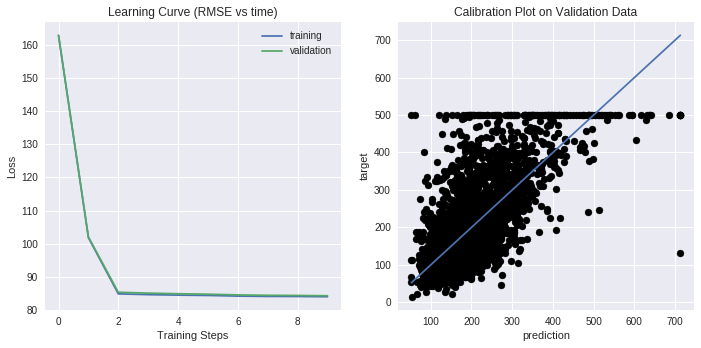

In [154]:
# Fill in the features you want to use "median_income_per_person",
NUMERICAL_FEATURES = [ "median_income_per_household", "median_income"]
LABEL = "median_house_value"

LEARNING_RATE = .025
STEPS = 1500
BATCH_SIZE = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(
    linear_regressor, training_examples[NUMERICAL_FEATURES],
    training_examples[LABEL], validation_examples[NUMERICAL_FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

You can look at the weights of the trained model.

In [159]:
# Let's also look at the weights and bias
print (linear_regressor.get_variable_names())
for feature in NUMERICAL_FEATURES:
  print ("weight for", feature, ":", linear_regressor.get_variable_value(
    "linear/linear_model/" + feature + "/weights")[0])
print ("bias:",  linear_regressor.get_variable_value("linear/linear_model/bias_weights"))

['global_step', 'linear/linear_model/bias_weights', 'linear/linear_model/median_income/weights', 'linear/linear_model/median_income_per_household/weights']
weight for median_income_per_household : [-0.88068247]
weight for median_income : [45.581142]
bias: [29.653286]


Check the loss on the test data after you are done selecting the learning rate and number of steps to run.

In [160]:
# Here we define an input function that will compute the loss over the entire
# training set.
features = test_examples[NUMERICAL_FEATURES]
targets = test_examples[LABEL]
predict_test_input_fn = lambda: input_fn(features, targets, num_epochs=1,
                                         shuffle=False)
# Fill in the rest to complete this.

# Use the predict method to compute the training loss
predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
testing_loss = compute_loss(predictions, targets)
print("Final Loss (RMSE) on the test data: %0.3f" % testing_loss) 

Final Loss (RMSE) on the test data: 84.149


In [109]:
"""
Here's a place for you to answer these questions:


A) Summarize the changes you made that were the most important.
 
1. The most important quadratic feature that I created  was getting to know the 
amount of people per household.
2. The second was to calculate the median income per person.
3. The most important synthethic feature that I created was 
"median_income_per_household". As we know already from Lab 6 median_income 
is important given that the more people get paid the more expensive it is to live.
So I decided to calculate the median_income per household, because the more income
there is in a household I would assume the more expensive is the household
because the more people can spend on it. I achieved this with the formula:
   **combination of 2 steps before**
          (population/household)*(median_income/person)

**Did 6 synthetic transformations but were not that significant when training***

B) If you train your model longer do you notice the training loss going lower
than the validation loss?  When this happens, how does the test loss compare
to the training and validation loss?  What do you think is happening?

Yes. I believe that the model starts to overfit, causing the model to stop generalizing well.
And not doing its purpose. Because the purpose of a model is to generalize to new unseen data.
I think if this particular scenario happens the test loss would be bigger than usual.

"""

"\nHere's a place for you to answer these questions:\n\n\nA) Summarize the changes you made that were the most important.\n\n\nB) If you train your model longer do you notice the training loss going lower\nthan the validation loss?  When this happens, how does the test loss compare\nto the training and validation loss?  What do you think is happening?\n\n"